In [1]:
import pandas as pd
import torch
import json
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertForSequenceClassification
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score, average_precision_score, matthews_corrcoef, confusion_matrix, roc_curve, precision_recall_curve
from torch.utils.data import Dataset
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np

# Load the data
with open('/content/Ecare_3.json', 'r') as f:
    ecare_1 = [json.loads(line) for line in f]

# Define split sizes for a 75-25 split of the data
train_size = int(0.75 * len(ecare_1))
train_data = ecare_1[:train_size]
validation_data = ecare_1[train_size:]

class EcareDataset(Dataset):
    def __init__(self, ecare_data, tokenizer):
        self.ecare_data = ecare_data
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.ecare_data)

    def __getitem__(self, idx):
        data = self.ecare_data[idx]
        premise = data['premise']
        hypotheses = [data['hypothesis1'], data['hypothesis2']]
        label = data['label']

        encoded_input = self.tokenizer(premise, hypotheses, padding='max_length', truncation=True, max_length=512, return_tensors='pt')
        input_ids = encoded_input['input_ids'].squeeze(0)
        attention_mask = encoded_input['attention_mask'].squeeze(0)
        label = torch.tensor(label)

        return {'input_ids': input_ids, 'attention_mask': attention_mask, 'labels': label}

# Load tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained('bert-base-uncased')

ecare_dataset = EcareDataset(train_data, tokenizer)
dataloader = DataLoader(ecare_dataset, batch_size=8, shuffle=True)

optimizer = optim.Adam(model.parameters(), lr=1e-5)
loss_fn = torch.nn.CrossEntropyLoss()

# Training loop
model.train()
for epoch in range(3):
    for batch in dataloader:
        optimizer.zero_grad()
        input_ids = batch['input_ids']
        attention_mask = batch['attention_mask']
        labels = batch['labels']

        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss

        loss.backward()
        optimizer.step()
        print(f"Epoch: {epoch}, Loss: {loss.item()}")

validation_dataset = EcareDataset(validation_data, tokenizer)
validation_dataloader = DataLoader(validation_dataset, batch_size=64)

model.eval()
y_true, y_pred, y_scores = [], [], []

def compute_metrics(y_true, y_pred, y_prob):
    accuracy = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    roc_auc = roc_auc_score(y_true, y_prob)
    pr_auc = average_precision_score(y_true, y_prob)
    mcc = matthews_corrcoef(y_true, y_pred)
    conf_matrix = confusion_matrix(y_true, y_pred)
    return accuracy, f1, precision, recall, roc_auc, pr_auc, mcc, conf_matrix

with torch.no_grad():
    for batch in validation_dataloader:
        input_ids = batch['input_ids'].squeeze(1)
        attention_mask = batch['attention_mask'].squeeze(1)
        labels = batch['labels']

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        predictions = torch.argmax(outputs.logits, dim=1)
        y_scores_batch = torch.softmax(outputs.logits, dim=1)[:, 1].cpu().numpy()

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predictions.cpu().numpy())
        y_scores.extend(y_scores_batch)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch: 0, Loss: 0.8457196950912476
Epoch: 0, Loss: 0.6493866443634033
Epoch: 0, Loss: 0.8609597682952881
Epoch: 0, Loss: 0.752433180809021
Epoch: 0, Loss: 0.6774636507034302
Epoch: 0, Loss: 0.7393262386322021
Epoch: 0, Loss: 0.7321493625640869
Epoch: 0, Loss: 0.7355197668075562
Epoch: 0, Loss: 0.6799963116645813
Epoch: 0, Loss: 0.6773884892463684
Epoch: 0, Loss: 0.697007417678833
Epoch: 0, Loss: 0.7565096616744995
Epoch: 0, Loss: 0.7446054220199585
Epoch: 0, Loss: 0.7549759149551392
Epoch: 0, Loss: 0.6716457605361938
Epoch: 0, Loss: 0.6899099946022034
Epoch: 0, Loss: 0.6473393440246582
Epoch: 0, Loss: 0.6822472214698792
Epoch: 0, Loss: 0.7226434946060181
Epoch: 0, Loss: 0.695393443107605
Epoch: 0, Loss: 0.6887366771697998
Epoch: 0, Loss: 0.7135236263275146
Epoch: 0, Loss: 0.7523407936096191
Epoch: 0, Loss: 0.7204137444496155
Epoch: 0, Loss: 0.6536380052566528
Epoch: 0, Loss: 0.6830980777740479
Epoch: 0, Loss: 0.7158142328262329
Epoch: 0, Loss: 0.6857589483261108
Epoch: 0, Loss: 0.71493

In [2]:
# Calculate metrics
accuracy, f1, precision, recall, roc_auc, pr_auc, mcc, conf_matrix = compute_metrics(y_true, y_pred, y_scores)

print(f"Accuracy: {accuracy:.4f}")
print(f"F1: {f1:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"ROC-AUC: {roc_auc:.4f}")
print(f"PR-AUC: {pr_auc:.4f}")
print(f"MCC: {mcc:.4f}")
print("Confusion Matrix:")
print(conf_matrix)

Accuracy: 0.5400
F1: 0.6628
Precision: 0.5280
Recall: 0.8898
ROC-AUC: 0.5178
PR-AUC: 0.5304
MCC: 0.0977
Confusion Matrix:
[[ 22 101]
 [ 14 113]]


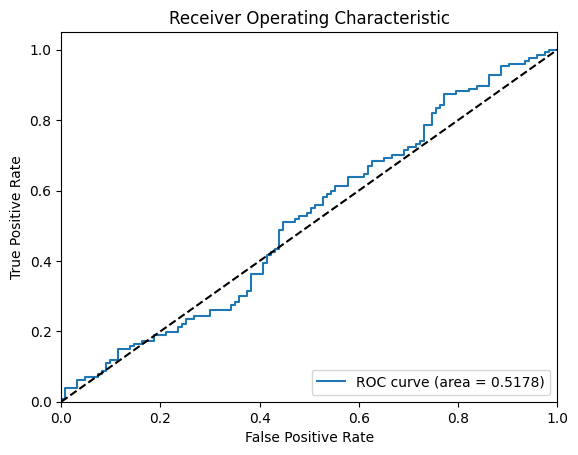

In [3]:
# Plot ROC-AUC curve
fpr, tpr, thresholds = roc_curve(y_true, y_scores)
plt.figure(1)
plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

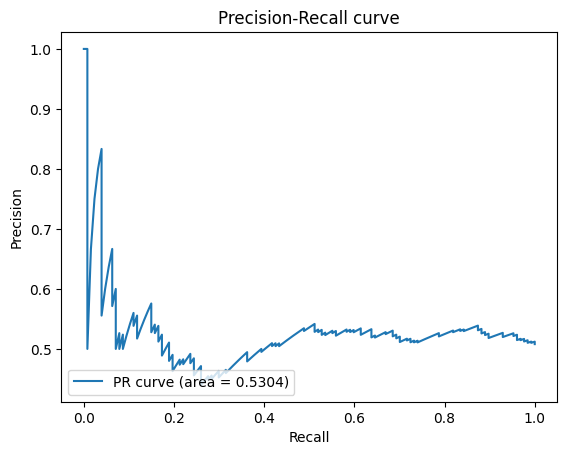

In [4]:
# Plot PR-AUC curve
precision_array, recall_array, _ = precision_recall_curve(y_true, y_scores)
plt.figure(2)
plt.plot(recall_array, precision_array, label=f'PR curve (area = {pr_auc:.4f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.legend(loc="lower left")
plt.show()